# Plotting a house in 3D

The goal of this notebook is to let and end user generate a 3D plot of the house or building on a specified address within Flanders, Belgium. The main dataset being used to do this is publicly available, and originates from a governmental project called [DHMV II](https://overheid.vlaanderen.be/dhm-digitaal-hoogtemodel-vlaanderen-ii) to update the [Digital Elevation Model](https://en.wikipedia.org/wiki/Digital_elevation_model) of Flanders between 2013 and 2015.

**Usage hint for this notebook: select the `Cell` menu, then `Run All`.**

## Background

The Flemish government provides a variety of elevation-related datasets within the DHMV II, and multiple ways to access them. Datasets are categorized in:
* [Source data](https://overheid.vlaanderen.be/dhm-dhmv-ii-brondata)
* [Standard products](https://overheid.vlaanderen.be/dhm-dhmv-ii-standaard-producten)
* [Test data](https://overheid.vlaanderen.be/DHM-DHMV-II-testdata)

To calculate a Digital Elevation Model (DEM), we want to subtract Digital Terrain Model (DTM) raster data from Digital Surface Model (DSM) raster data. 

Within the *standard products* and *test data* categories, there are DSM and DTM raster datasets with a resolution of 1m or 5m per pixel. We will work with the 1m datasets.

According to [the documentation](https://overheid.vlaanderen.be/dhm-dhmv-ii-standaard-producten), the DSM and DTM raster datasets with a 1m resolution are available:
* to view on a height map at [Geopunt](http://www.geopunt.be/)
* to use via a [Web Map Service (WMS)](https://en.wikipedia.org/wiki/Web_Map_Service)
* to download

Currently, the notebook works with manually downloaded files. (See [further](#Build-a-height-model))

## Import the necessary modules

In [89]:
import pandas as pd
import plotly.graph_objects as go
import rasterio
import rasterio.plot
from rasterio.plot import show
import requests

## Location of the building

We'll use an API to get coordinates for an address first. The API's documentation can be found [here](http://loc.geopunt.be/).

### Enter an address

In [64]:
q = input("Please provide the address of the building to plot. The preferred way is to provide zip code, street name and house number of a valid address in Flanders. Your address:")

Please provide the address of the building to plot. The preferred way is to provide zip code, street name and house number of a valid address in Flanders. Your address:Stationsplein 34 9500


### Get it's coordinates

In [65]:
loc_api_url = "http://loc.geopunt.be/geolocation/location"
loc_api_params = {"q": q}

loc_api_req = requests.get(loc_api_url, loc_api_params)

In [66]:
loc_api_resp = loc_api_req.json()["LocationResult"][0]
geoloc = loc_api_resp["Location"]

In [67]:
geoloc["Y_Lambert72"]

162304.58

In [68]:
loc_api_resp

{'Municipality': 'Geraardsbergen',
 'Zipcode': '9500',
 'Thoroughfarename': 'Stationsplein',
 'Housenumber': '34',
 'ID': 1589943,
 'FormattedAddress': 'Stationsplein 34, 9500 Geraardsbergen',
 'Location': {'Lat_WGS84': 50.77018540581181,
  'Lon_WGS84': 3.8728880497997507,
  'X_Lambert72': 115021.85,
  'Y_Lambert72': 162304.58},
 'LocationType': 'crab_huisnummer_afgeleidVanGebouw',
 'BoundingBox': {'LowerLeft': {'Lat_WGS84': 50.77018540581181,
   'Lon_WGS84': 3.8728880497997507,
   'X_Lambert72': 115021.85,
   'Y_Lambert72': 162304.58},
  'UpperRight': {'Lat_WGS84': 50.77018540581181,
   'Lon_WGS84': 3.8728880497997507,
   'X_Lambert72': 115021.85,
   'Y_Lambert72': 162304.58}}}

In [69]:
loc_api_resp["Housenumber"]

'34'

### Validation checks

*Currently not implemented. Maybe something for a future release.*

## Shape of the building

We'll use another API to get the shape of the building.

In [70]:
# Set the base API url
br_api_url = "https://api.basisregisters.vlaanderen.be/v1/"

# First perform an address lookup
addr_api_url = br_api_url + "adresmatch"
addr_api_params = {"postcode": loc_api_resp["Zipcode"], 
                   "straatnaam": loc_api_resp["Thoroughfarename"], 
                   "huisnummer": loc_api_resp["Housenumber"]}

addr_api_req = requests.get(addr_api_url, addr_api_params)
addr_api_resp = addr_api_req.json()

In [71]:
# Next perform a building unit (gebouweenheid) lookup
gbe_api_url = addr_api_resp["adresMatches"][0]["adresseerbareObjecten"][0]["detail"]
# note that the code above might give errors
# it only uses index 0 from lists

gbe_api_req = requests.get(gbe_api_url)
gbe_api_resp = gbe_api_req.json()

In [72]:
# Then perform a building (gebouw) lookup
gb_api_url = gbe_api_resp["gebouw"]["detail"]

gb_api_req = requests.get(gb_api_url)
gb_api_resp = gb_api_req.json()

In [73]:
# Finally extract the polygon to get the shape
gb_api_resp["geometriePolygoon"]

{'polygon': {'coordinates': [[[115028.02603507787, 162295.834930785],
    [115032.02987508476, 162302.00216278806],
    [115027.7343230769, 162302.94833879173],
    [115029.80702707916, 162311.4679547958],
    [115018.06200307608, 162313.9570427984],
    [115016.00798707455, 162312.66398679838],
    [115011.67403506488, 162300.650034789],
    [115027.42891507596, 162294.61579478532],
    [115028.02603507787, 162295.834930785]]],
  'type': 'Polygon'}}

## Build a height model

### Get the DSM & DTM for the area

*Note: * the commented code below doesn't work yet. The idea is to use a [WCS](https://en.wikipedia.org/wiki/Web_Coverage_Service) to request DSM and DTM for the location. A working url to download a DTM is [this one](https://inspire.informatievlaanderen.be/overdrachtdiensten/el-dtm/wcs?SERVICE=WCS&VERSION=1.0.0&REQUEST=GetCoverage&CRS=EPSG:4258&BBOX=4.25486589326289,50.7461998135595,4.54180360703703,50.910858515163&WIDTH=1278&HEIGHT=1009&COVERAGE=EL.GridCoverage.DTM&FORMAT=GeoTIFF&RESPONSE_CRS=EPSG:31370). When you click it, a tiff raster gets sent back, proving it's feasible. However, there are some difficulties in modifying the parameters, and the documentation I've found is vague, so I was still looking into it. Due to a lack of time, I had to stop.

In [82]:
"""
# First calculate a bounding box for the DSM & DTM requests
l, r = geoloc["Lat_WGS84"], geoloc["Lat_WGS84"]
b, t = geoloc["Lon_WGS84"], geoloc["Lon_WGS84"]

bbox = "{l},{b},{r},{t}".format(l=l, b=b, r=r, t=t)
"""
pass

In [83]:
"""
# for testing
bbox
"""
pass

In [84]:
"""
wcs_api_url = "https://inspire.informatievlaanderen.be/overdrachtdiensten/"

dsm_api_url = wcs_api_url + "el-dsm/wcs"
dsm_api_params = {"service" : "WCS",
                  "request" : "getcoverage",
                  "version": "1.0.0",
                  "CRS": "EPSG:4326",
                  "bbox": bbox,  # to fix: bbox of a point doesn't work
                  "coverage": "EL.GridCoverage.DSM",
                  "format": "GeoTIFF",
                  "response_crs":"EPSG:31370",
                  "width":200,  # how do we get the right value here?
                  "height":200}  # and here?

dtm_api_url = wcs_api_url + "el-dtm/wcs"
dtm_api_params = {}  # todo
"""
pass

Because the code above doesn't work yet, I only worked with a small downloaded DSM and DTM dataset. This can be found here:
* [DSM](https://downloadagiv.blob.core.windows.net/dhm-vlaanderen-ii-dsm-raster-1m-testdata/Digitaal_Hoogtemodel_Vlaanderen+II_DSM_raster_1m_testdata.zip)
* [DTM](https://downloadagiv.blob.core.windows.net/dhm-vlaanderen-ii-dtm-raster-1m-testdata/Digitaal_Hoogtemodel_Vlaanderen+II_DTM_raster_1m_testdata.zip)

Alternatively the complete 43 DSM / DTM files can be found here:
* [all DSM's](http://www.geopunt.be/download?container=dhm-vlaanderen-ii-dsm-raster-1m&title=Digitaal%20Hoogtemodel%20Vlaanderen%20II,%20DSM,%20raster,%201m)
* [all DTM's](http://www.geopunt.be/download?container=dhm-vlaanderen-ii-dtm-raster-1m&title=Digitaal%20Hoogtemodel%20Vlaanderen%20II,%20DTM,%20raster,%201m)

In [77]:
# for now, you have to set the path to the tiff files you want to use
dsm_path = "D:/tmp/dhmv/data/dsm/00.tif"
dtm_path = "D:/tmp/dhmv/data/dtm/00.tif"

In [78]:
# open the files (returns a DatasetReader object)
dsm_dsr = rasterio.open(dsm_path)
dtm_dsr = rasterio.open(dtm_path)

In [79]:
# read the files (returns a numpy ndarray object)
dsm_data = dsm_dsr.read(1)
dtm_data = dtm_dsr.read(1)

In [80]:
# find the coordinates in the dataset using the .index(x, y) method
# the method should return the index of a pixel where the address is
ind_x, ind_y = dsm_dsr.index(geoloc["X_Lambert72"], geoloc["Y_Lambert72"])

# now we can select an area around the pixel
# e.g. 100 px left, right, up and down
radius = 25
l, r = ind_x - radius, ind_x + radius  # left & right
b, t = ind_y - radius, ind_y + radius  # bottom & top
# note that using this might cause errors if you're too close to the bbox

In [81]:
surface = dsm_data[l:r, b:t]
terrain = dtm_data[l:r, b:t]

### Calculate the DEM

In [87]:
height_model = surface - terrain

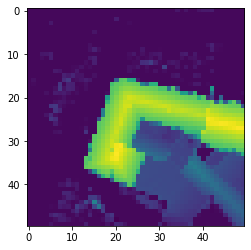

<AxesSubplot:>

In [88]:
show(height_model)

### mask the surroundings

*Not implemented yet. Maybe in a future release.*

## Visualize in 3D

### Convert the height model to a DataFrame object

In [90]:
df = pd.DataFrame(height_model)

In [95]:
fig = go.Figure(data=[go.Surface(z=df.values)])

In [94]:
fig.update_scenes(yaxis_autorange="reversed")  # fix for the mirroring
fig.show()